# Importing libraries and loading datasets

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import seaborn as sns
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization,Conv1D,MaxPooling1D
import warnings
warnings.filterwarnings("ignore")

**Loading the Ravdess dataset**

In [2]:
ravdess="/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
ravdess_directory_list = os.listdir(ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + dir + '/' + file)
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)

ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
ravdess_df.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


**Loading the Crema dataset**

In [3]:
crema_path = "/kaggle/input/cremad/AudioWAV/"
crema_directory_list = os.listdir(crema_path)

file_emotion = []
file_path = []

for file in crema_directory_list:
    file_path.append(crema_path + file)
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
crema_df = pd.concat([emotion_df, path_df], axis=1)
crema_df.head()

,Emotions,Path
0,disgust,/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1,happy,/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2,happy,/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3,disgust,/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4,disgust,/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav


**Concatenating both the datasets**

In [4]:
df = pd.concat([ravdess_df, crema_df], axis = 0)
df.to_csv("df.csv",index=False)
df.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


# Overview of the dataset

In [5]:
df.Emotions.value_counts()

Emotions
fear        1463
disgust     1463
happy       1463
sad         1463
angry       1463
neutral     1183
surprise     192
calm         192
Name: count, dtype: int64

**Removing suprise and calm emotions since very few audio files available**

In [6]:
df = df[df['Emotions'] != 'calm']
df = df[df['Emotions'] != 'surprise']

**Final list of Emotions**

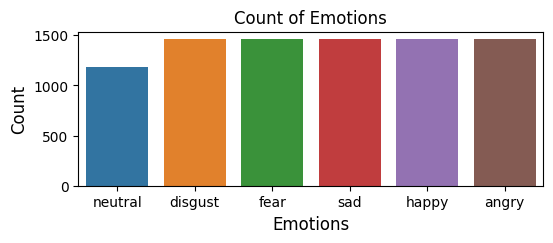

In [7]:
plt.figure(figsize=(6,2))
plt.title('Count of Emotions')
sns.countplot(x='Emotions', data=df)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.show()

**Plotting sample images of each emotion's mel spectrogram**

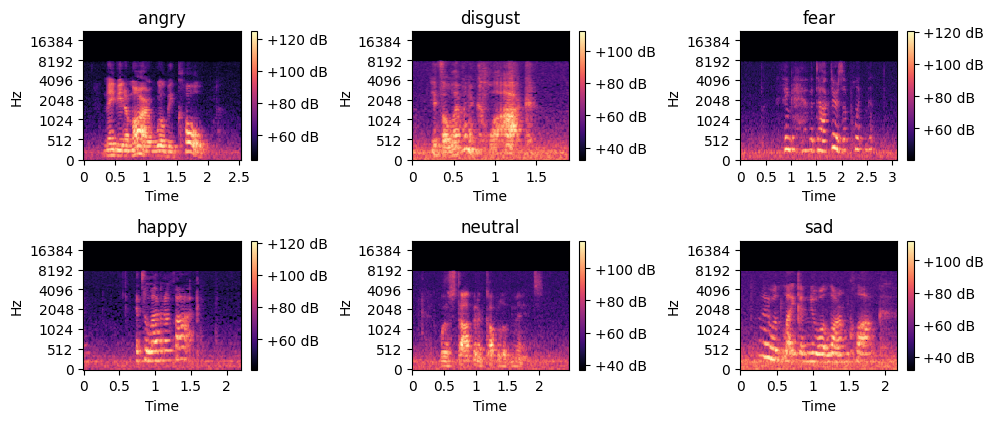

In [8]:
#extracting sample emotions of each kind
sample = df.groupby('Emotions', group_keys=False).apply(lambda x: x.sample(1))
# extracting the paths from the sample
sample_paths = sample['Path'].tolist()
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(3, 3, i+1)
    signal, sr = librosa.load(sample_paths[i], sr=44100)     # Loading the audio file
    signal = librosa.feature.melspectrogram(y = signal, sr=sr)
    signal = librosa.power_to_db(signal, ref=np.min)
    librosa.display.specshow(signal, sr=sr, x_axis='time', y_axis='mel')     # Plotting the spectrogram
    plt.title(sample['Emotions'].values[i])
    plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

**Plotting MFCCs of each emotion's sample**

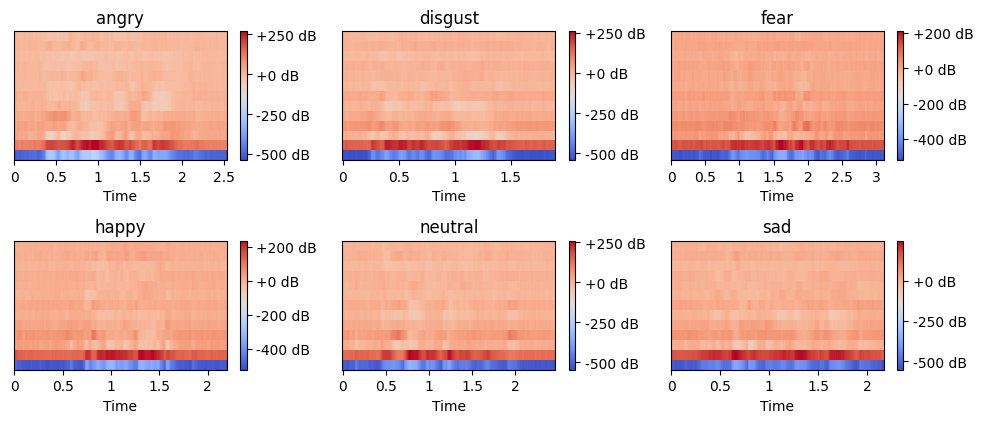

In [20]:
plt.figure(figsize=(10, 6))
# Plotting MFCCs
for i in range(6):
    plt.subplot(3, 3, i+1)
    y, sr = librosa.load(sample_paths[i], sr = 44100)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(sample['Emotions'].values[i])
plt.tight_layout()

**Plotting waveform of each emotion's sample**

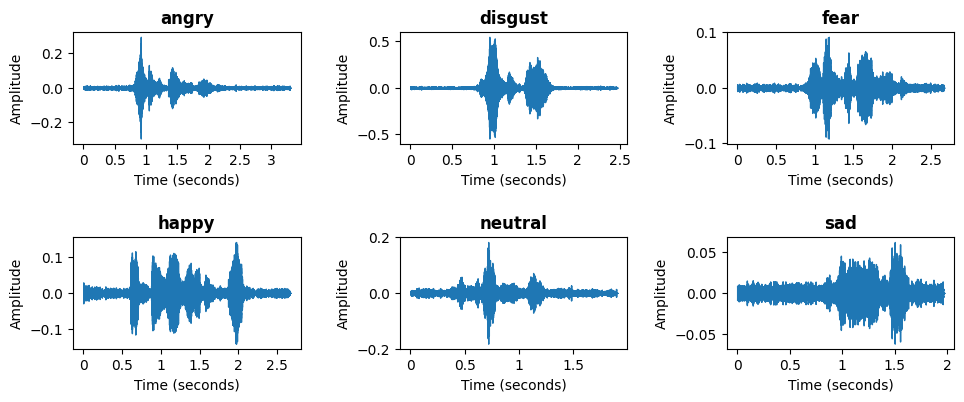

In [49]:
plt.figure(figsize=(10,6))
for i in range(6):
    plt.subplot(3, 3, i+1)
    data, sr = librosa.load(sample_paths[i], sr = 44100)
    librosa.display.waveshow(data, sr=sr)
    plt.title(sample['Emotions'].values[i], fontweight='bold')
    plt.ylabel('Amplitude')
    plt.xlabel('Time (seconds)')
plt.tight_layout(pad=2)

**Plotting RMS Energy of each emotion's sample**

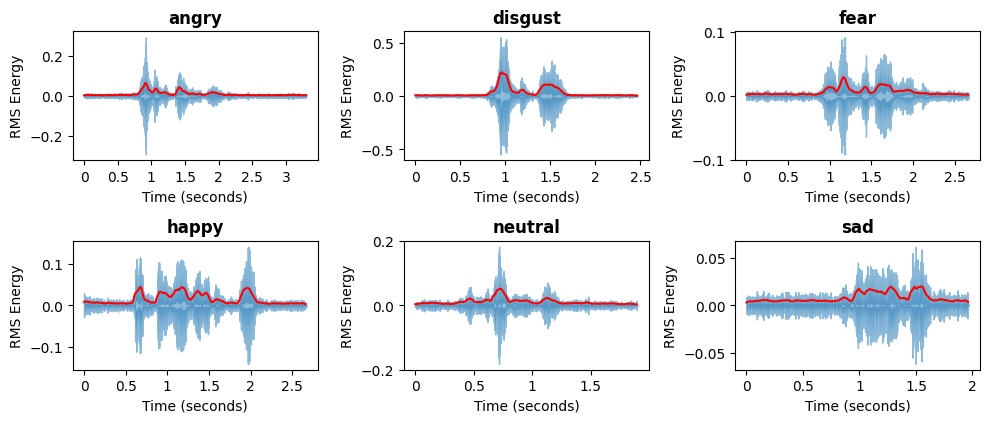

In [50]:
frame_length = 2048
hop_length = 512
plt.figure(figsize=(10, 6))
# Plotting RMS energy
for i in range(6):
    plt.subplot(3, 3, i+1)
    y, sr = librosa.load(sample_paths[i], sr = 44100)
    librosa.display.waveshow(y=y, sr=sr,alpha=0.5)
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)
    times = librosa.times_like(rms, sr=sr, hop_length=hop_length)
    plt.plot(times, rms[0],color='r')
    plt.title(sample['Emotions'].values[i], fontweight='bold')
    plt.xlabel("Time (seconds)")
    plt.ylabel("RMS Energy")
plt.tight_layout()

**Plotting ZCR of each emotion's sample**

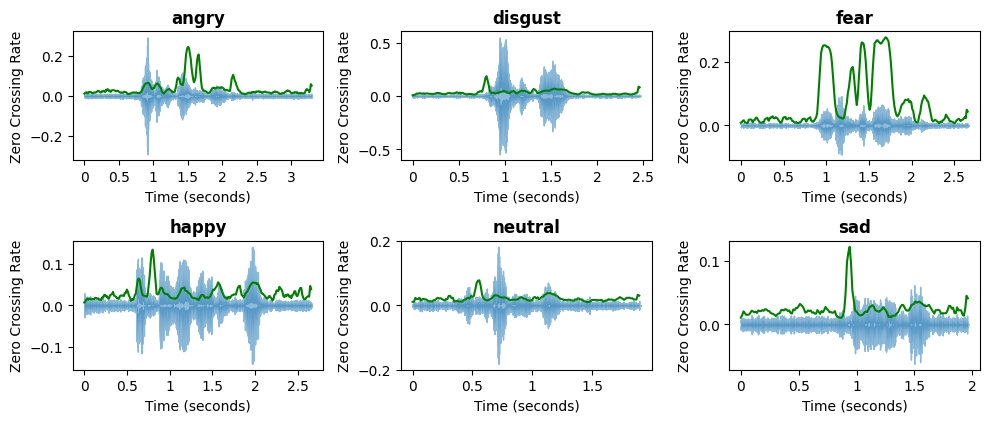

In [51]:
plt.figure(figsize=(10, 6))
# Plotting Zero Crossing Rate
for i in range(6):
    plt.subplot(3, 3, i+1)
    y, sr = librosa.load(sample_paths[i], sr = 44100)
    librosa.display.waveshow(y=y, sr=sr,alpha=0.5)
    zcr = librosa.feature.zero_crossing_rate(y=y, frame_length=frame_length, hop_length=hop_length)
    times = librosa.times_like(zcr, sr=sr, hop_length=hop_length)
    plt.plot(times, zcr[0],color='g')
    plt.title(sample['Emotions'].values[i], fontweight='bold')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Zero Crossing Rate")
plt.tight_layout()

# Preparing a dataset containing mel-spectrograms, MFCCs (Mel-frequency Cepstral Coefficients), ZCR (Zero Crossing Rate), RMS (Root Mean Square Energy) of each audio file

Each audio contains various features.
1. Time domain features: These features are extracted directly from the waveform of the audio signal.
   * Zero-Crossing Rate: Zero Crossing Rate is the rate at which the signal changes from positive to negative or vice versa. It provides information about the frequency content of the signal. 
   * Root Mean Square Energy: RMS Energy is a measure of the signal’s overall energy or loudness over time. It provides insight into the amplitude variations of the audio signal.
2. MFCCs:
   Mel-frequency Cepstral Coefficients (MFCCs) provide a compact representation of the spectral envelope of a sound that closely relates to how humans perceive pitch and frequency content.
3. Mel-Spectrograms:
   A mel spectrogram shows how the frequency content of the signal changes over time.

In [52]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

mel_spectrograms = []
zcr_list = []
mfcc_list = []
rms_list = []
labels = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512
MAX_LEN = 130  # target length for padding

# Iterating over each row in the DataFrame s
for index, row in df.iterrows():
    y, sr = librosa.load(row['Path'], sr=None)

    # Mel Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram)  
    mel_spectrogram_db = pad_sequences([mel_spectrogram_db.T], maxlen=MAX_LEN, padding='post', truncating='post')

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
    zcr = pad_sequences([zcr.T], maxlen=MAX_LEN, padding='post', truncating='post')

    # Root Mean Square (RMS)
    rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
    rms = pad_sequences([rms.T], maxlen=MAX_LEN, padding='post', truncating='post')

    # MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)
    mfcc = pad_sequences([mfcc.T], maxlen=MAX_LEN, padding='post', truncating='post')

    # Adding features to respective lists
    mel_spectrograms.append(mel_spectrogram_db)
    zcr_list.append(zcr)
    rms_list.append(rms)
    mfcc_list.append(mfcc)
    labels.append(row['Emotions'])

# Defining X,y; Preprocessing; Encoding; Splitting the dataset;

In [53]:
# Converting lists to numpy arrays
X = np.concatenate([np.array(mel_spectrograms), np.array(zcr_list), np.array(rms_list), np.array(mfcc_list)], axis=-1)
X = X.astype('float32')

y = np.asarray(labels)

**Encoding the emotion labels**

In [54]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Converting labels to integers
y_one_hot = to_categorical(y_encoded)

**Splitting into training and testing data**

In [55]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y_one_hot,random_state=102,test_size=0.2,shuffle=True)

In [56]:
X_train.shape

(6798, 1, 130, 79)

**Standardising the data**

In [57]:
mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

**Reshaping the standardized data to give as input in the model**

In [58]:
X_train = X_train.reshape(X_train.shape[0],130,79)
X_test = X_test.reshape(X_test.shape[0],130,79)

In [59]:
X_train.shape #Checking the shape of final X_train

(6798, 130, 79)

# Defining the model

**Defining early stopping callbacks to prevent overfitting by monitoring validation loss**

In [60]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode = 'min')

**Defining/Compiling the model architecture**

In [61]:
model=Sequential([
    Conv2D(32,kernel_size=3,activation='relu',input_shape=(130,79,1)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32,kernel_size=3,activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),

    Conv2D(64,kernel_size=3,activation='relu',input_shape=(130,79,1)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64,kernel_size=3,activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(128,kernel_size=3,activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128,kernel_size=3,activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    
    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.5),
    Dense(6,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 128, 77, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 64, 38, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 64, 38, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 32, 19, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 32, 19, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 30, 17, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 15, 8, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 15, 8, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 7, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 7, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 7, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 3, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 3, 2, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 320,998 (1.22 MB)

 Trainable params: 320,998 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

**Fitting the model with the training data**

In [62]:
history=model.fit(X_train,y_train,validation_split=0.2,epochs=100,batch_size=32,callbacks=[early_stopping])

Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.2239 - loss: 1.7350 - val_accuracy: 0.3853 - val_loss: 1.5202
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3508 - loss: 1.5273 - val_accuracy: 0.3890 - val_loss: 1.4909
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3890 - loss: 1.4927 - val_accuracy: 0.4294 - val_loss: 1.4143
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4092 - loss: 1.4516 - val_accuracy: 0.4243 - val_loss: 1.4301
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4289 - loss: 1.4189 - val_accuracy: 0.4272 - val_loss: 1.3991
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4217 - loss: 1.4085 - val_accuracy: 0.4551 - val_loss: 1.3673
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4329 - loss: 1.4036 - val_accuracy: 0.4574 - val_loss: 1.3511
Epoch 8/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4421 - loss: 1.3843 - val_ac

**Loss and accuracy on testing data**

In [63]:
loss, accuracy = model.evaluate(X_test,y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {100*accuracy:.2f}%')

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5656 - loss: 1.1101
Test Loss: 1.1627
Test Accuracy: 56.00%


**Plots to depict the loss and accuracy of the model with epochs**

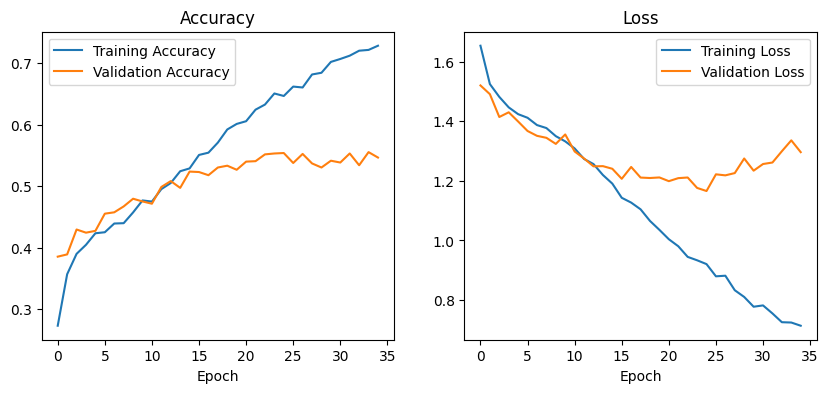

In [64]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

# Final predictions and evaluation metrics

**Predictions on testing data**

In [71]:
# Predicting on test data
pred = model.predict(X_test)
y_pred = np.argmax(pred, axis=1)  
y_test_classes = np.argmax(y_test, axis=1)  

# Decoding classes indices back to emotions
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test_classes)

# Checking for random predictions
df_pred = pd.DataFrame({
    'Predicted Labels': y_pred_labels,
    'Actual Labels': y_test_labels
})

df_pred.iloc[140:145]


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,Predicted Labels,Actual Labels
140,angry,angry
141,angry,angry
142,sad,sad
143,neutral,neutral
144,neutral,happy


**Classification Report**  

In [66]:
from sklearn.metrics import classification_report
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

       angry       0.72      0.62      0.67       298
     disgust       0.50      0.57      0.53       283
        fear       0.53      0.41      0.46       272
       happy       0.46      0.58      0.51       289
     neutral       0.59      0.68      0.63       248
         sad       0.61      0.51      0.55       310

    accuracy                           0.56      1700
   macro avg       0.57      0.56      0.56      1700
weighted avg       0.57      0.56      0.56      1700



**Confusion Matrix**

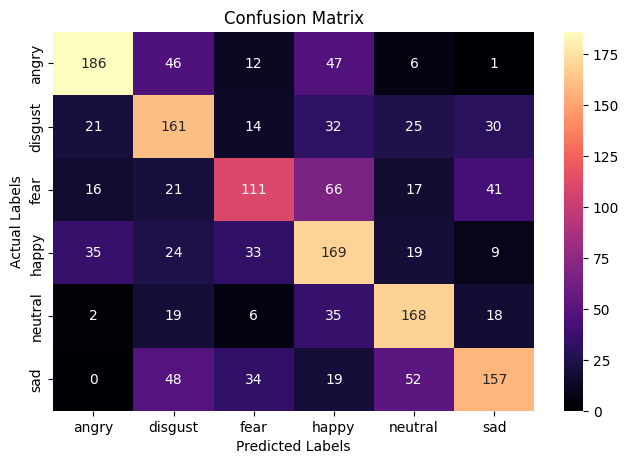

In [67]:
cm = tf.math.confusion_matrix(y_test_classes, y_pred)
plt.figure(figsize=(7,5))
cm = pd.DataFrame(cm.numpy(), index=label_encoder.classes_, columns=label_encoder.classes_) 
sns.heatmap(cm, annot=True, fmt='', cmap='magma')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.tight_layout(pad=2)